In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score
import nltk
from nltk import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import advertools as adv
from datetime import datetime
import seaborn as sns
import pattern
from pattern.en import lemma, lexeme
from pattern.en import parse
from wordcloud import WordCloud

nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

import re

def cleaning_text(text): #Clean text by removing @mentions, hashtags, URLs, and non-alphabetic characters.
    text = re.sub(r'\\n|\n', ' ', text)     # Remove newlines
    text = re.sub(r'@[A-Za-z0-9]+', '', text)     # Remove
    text = re.sub(r'#\S+', '', text)     # Remove hashtags
    text = re.sub(r'https?://\S+', '', text)     # Remove URLs
    text = re.sub(r'RT[\s]+', '', text)    # Remove RT (retweet)
    text = re.sub(r'[^a-zA-Z ]', '', text)     # Remove non-alphabetic characters and emojis
    text = re.sub(r'\s+', ' ', text).strip()     # Remove extra whitespace
    return text


def preprocess_text(text): #Creating the function to preprocess the text, removing stop words, converting to lower cases, lemmatizing
    merged_string = ''.join(text)
    corpus = word_tokenize(merged_string) #Tokenizing the text
    corpus  = [element.lower() for element in corpus ] #Converting to lower case
    stop_words = set(stopwords.words("english")) #Defining the stop words
    clean_text = []
    for i in corpus:
        clean_text.append(cleaning_text(i)) #Cleaning the text, to change the basic text changes need to be made in the cleaning_text function
    clean_text_list = []
    for word in clean_text: 
        if word.casefold() not in stop_words: #Removing the stop words
            clean_text_list.append(word)
    clean_text = []
    clean_text_pattern = []
    lemmatizer = WordNetLemmatizer()
    for word in clean_text_list:
        lemmatized_word = lemmatizer.lemmatize(word) #Lemmatizing the text with the WordNetLemmatizer
        clean_text.append(lemmatized_word)
        clean_text_pattern.append(lemma(word)) #Lemmatizing the text with the pattern lemmatizer

    words_to_remove = ['nn', 'n', 's', 'http', ' ', 'k', '']
    clean_text = [word for word in clean_text if word not in words_to_remove]
    return clean_text, clean_text_pattern


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nikit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nikit\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\nikit\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nikit\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


This is code for tweet processing. Run absolutely the same for both BTC and OP tweets. However, processing all OP tweets takes about 3 hours, so here is an example of BTC processing. 

In [2]:
pd.set_option('display.max_columns', None)

df = pd.read_csv("C:/Users/nikit/Downloads/crypto_preprocessed_description.csv")
df['Text'] = df["text"]
df['Cleaned'], df['Cleaned_Pattern'], df['Only_Emoji']  = 0, 0, 0
df['date'] = df["created_at"]
df = df[['date', 'Text', 'Cleaned','Cleaned_Pattern', 'Only_Emoji']]
df.head()

,date,Text,Cleaned,Cleaned_Pattern,Only_Emoji
0,2022-06-22T09:34:33.000Z,$BTC ltf\n\nLocal bottom formation between $16...,0,0,0
1,2022-06-22T15:39:33.000Z,Great move. Zero-fee $BTC trading can help to ...,0,0,0
2,2022-06-22T16:01:12.000Z,"With the release of @CoreApp_, the Avalanche B...",0,0,0
3,2022-06-22T16:32:19.000Z,Some mining pool participants from Poolin just...,0,0,0
4,2022-06-22T04:33:52.000Z,Crypto literally dumps during 100% of crypto m...,0,0,0


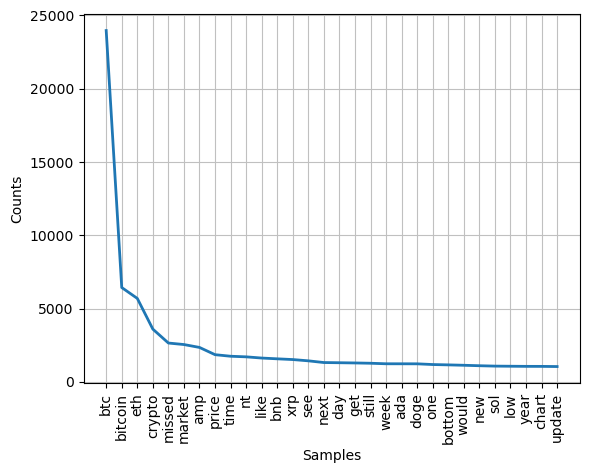

,date,Text,Cleaned,Cleaned_Pattern,Only_Emoji
0,2022-06-22T09:34:33.000Z,$BTC ltf\n\nLocal bottom formation between $16...,btc ltf local bottom formation kk tcovwtavonk,have btc ltf local bottom formation have kk ht...,
1,2022-06-22T15:39:33.000Z,Great move. Zero-fee $BTC trading can help to ...,great move zerofee btc trading help accelerate...,great move have zerofee have btc trade help ac...,
2,2022-06-22T16:01:12.000Z,"With the release of @CoreApp_, the Avalanche B...",release coreapp avalanche bridge added support...,release have coreapp have avalanche bridge add...,🤝
3,2022-06-22T16:32:19.000Z,Some mining pool participants from Poolin just...,mining pool participant poolin sent btc binanc...,mine pool participant poolin send k have btc h...,👇
4,2022-06-22T04:33:52.000Z,Crypto literally dumps during 100% of crypto m...,crypto literally dump crypto meetups another e...,crypto literally dump have have crypto meetup ...,


In [4]:
# Processing text for individual tweets
#Sometimes need to run this cell 2 times if there is an error
for i in range(len(df['Text'])):
   cleaned_text, cleaned_pattern_text = preprocess_text(df['Text'][i])
   df.at[i, 'Cleaned'] = " ".join(cleaned_text)
   df.at[i, 'Cleaned_Pattern'] = " ".join(cleaned_pattern_text)
   emo_list = adv.extract_emoji(df['Text'][i])['emoji'] #Getting the emoji only
   df.at[i, 'Only_Emoji'] = " ".join([item for sublist in emo_list for item in sublist])

# Processing text for all tweets as one body of text
clean_text = " ".join(df['Cleaned'].astype(str).tolist())

# Getting the frequency distribution of the words for entire corpus
words = word_tokenize(clean_text)
fdist = FreqDist(words)

# Plotting the frequency distribution
fdist.plot(30, cumulative=False)
plt.show()

df.head()

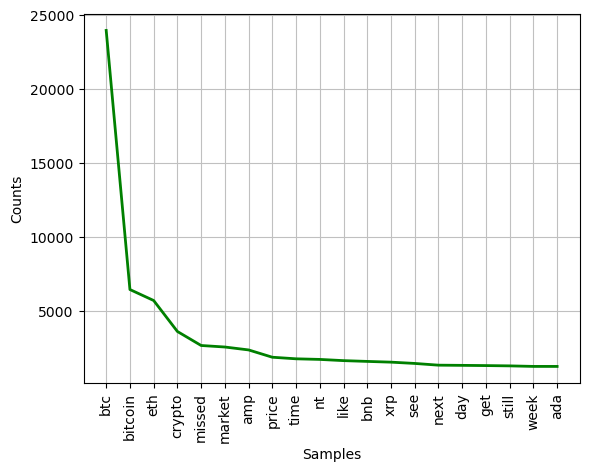

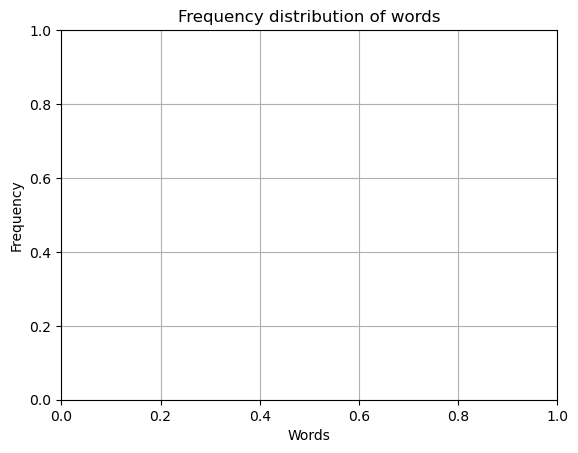

,date,Text,Cleaned,Cleaned_Pattern,Only_Emoji
0,2022-06-22T09:34:33.000Z,$BTC ltf\n\nLocal bottom formation between $16...,btc ltf local bottom formation kk tcovwtavonk,have btc ltf local bottom formation have kk ht...,
1,2022-06-22T15:39:33.000Z,Great move. Zero-fee $BTC trading can help to ...,great move zerofee btc trading help accelerate...,great move have zerofee have btc trade help ac...,
2,2022-06-22T16:01:12.000Z,"With the release of @CoreApp_, the Avalanche B...",release coreapp avalanche bridge added support...,release have coreapp have avalanche bridge add...,🤝
3,2022-06-22T16:32:19.000Z,Some mining pool participants from Poolin just...,mining pool participant poolin sent btc binanc...,mine pool participant poolin send k have btc h...,👇
4,2022-06-22T04:33:52.000Z,Crypto literally dumps during 100% of crypto m...,crypto literally dump crypto meetups another e...,crypto literally dump have have crypto meetup ...,


In [5]:
import matplotlib.pyplot as plt
from nltk import FreqDist, word_tokenize

words = word_tokenize(clean_text)
fdist = FreqDist(words)

#plt.figure(figsize=(12, 6))
#fdist
fdist.plot(20, cumulative=False, color='green') # increase font size to 14
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Frequency distribution of words')
plt.grid(True)
plt.show()

df.head()


C:\Users\nikit\AppData\Local\Temp\ipykernel_26932\2733090062.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df['date'].dt.strftime('%Y-%m-%d'), rotation=90) # add tick labels to the x-axis and rotate them


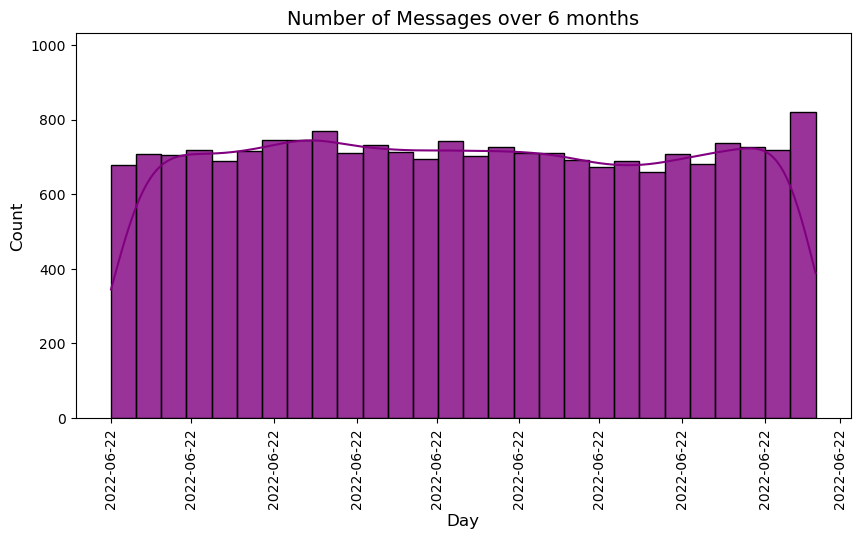

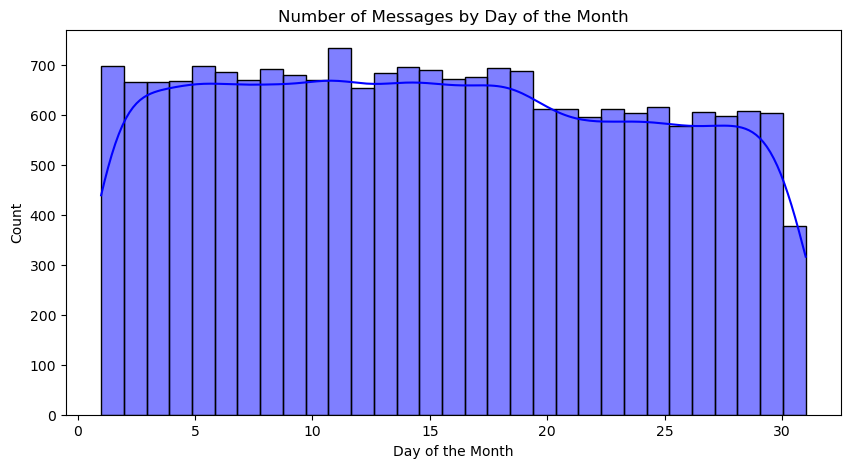

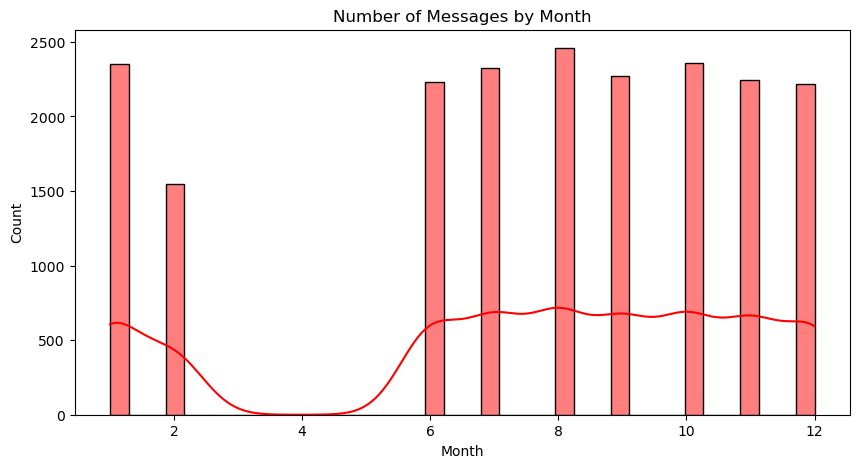

2023-03-03 22:17:24,461 | INFO | category.py:234 | update | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-03-03 22:17:24,466 | INFO | category.py:234 | update | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


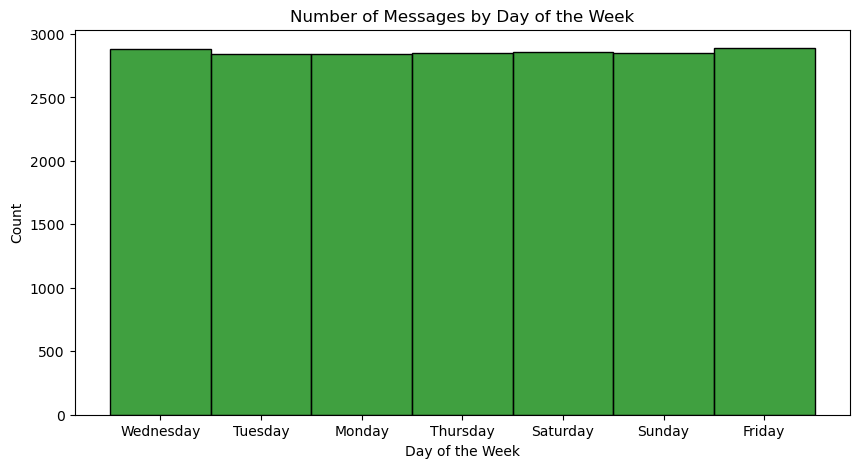

In [6]:
#Doing analysis of the data based on time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df['date'] = pd.to_datetime(df['date'])
df['day'], df['month'], df['week'] = 0, 0, 0

plt.figure(figsize=(10, 5))
ax = sns.histplot(data=df, x='date', kde=True, color='purple', alpha=0.8) # change the color of the histogram bars
ax.set_xlabel('Day', fontsize=12) # increase font size of x-axis label
ax.set_ylabel('Count', fontsize=12) # increase font size of y-axis label
ax.set_title('Number of Messages over 6 months', fontsize=14) # increase font size of title
ax.set_xticklabels(df['date'].dt.strftime('%Y-%m-%d'), rotation=90) # add tick labels to the x-axis and rotate them
ax.set_ylim(0, ax.get_ylim()[1]*1.2) # adjust y-axis limits for better view of data
plt.show()


# extract the day of the month from the date
df['day'] = df['date'].dt.day

# plot a histogram of the number of messages by day of the month
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='day', bins=df['day'].nunique(), kde=True, color='blue')
plt.title('Number of Messages by Day of the Month')
plt.xlabel('Day of the Month')
plt.ylabel('Count')
plt.show()

# extract the month from the date
df['month'] = df['date'].dt.month

# plot a histogram of the number of messages by month
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='month', kde=True, color='red')
plt.title('Number of Messages by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df['date'] = pd.to_datetime(df['date'])
df['week'] = df['date'].dt.strftime('%A') # extract the weekday name

plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='week', bins=df['week'].nunique(), color='green')
plt.title('Number of Messages by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Count')
plt.show()



In [7]:
emo = " ".join(df['Only_Emoji'].tolist())
emo = [x for x in emo if x != ' ']
emoji_freq = FreqDist(emo)
most_common = emoji_freq.most_common(10)
# Create a Pandas DataFrame from the list of tuples
EmojiDF = pd.DataFrame(most_common, columns=['Emoji', 'Count'])

# Print the DataFrame
print(EmojiDF)

  Emoji  Count
0     🔥   1352
1     🚀   1255
2     👇   1227
3     🔴    979
4     ✅    712
5     👀    647
6     ⚠    466
7     🚨    390
8     👉    386
9     📈    342


In [ ]:
fdist

FreqDist({'btc': 23968, 'bitcoin': 6436, 'eth': 5694, 'crypto': 3599, 'missed': 2650, 'market': 2547, 'amp': 2350, 'price': 1856, 'time': 1749, 'nt': 1708, ...})

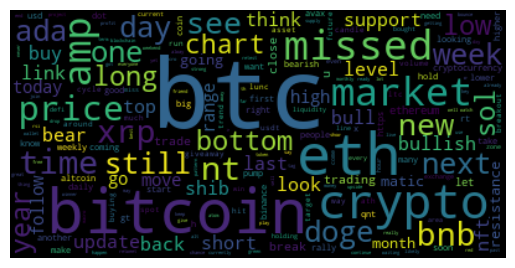

In [8]:
cloud = WordCloud(collocations=False).generate(clean_text)

plt.imshow(cloud , interpolation='bilinear')
plt.axis("off")
plt.show()

In [9]:
from textblob import TextBlob #More general library
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer #Library for small text sentiment
blob = TextBlob(clean_text)
sia = SentimentIntensityAnalyzer()
sentiment = blob.sentiment.polarity
print("Sentiment score for entire corpus:", sentiment)

df['Sentiment'] = 0
df['SentimentVader_neg'] = 0
df['SentimentVader_pos'] = 0
df['Sentiment_pat'] = 0
df['SentimentVader_neg_pat'] = 0
df['SentimentVader_pos_pat'] = 0
for i, tweet in enumerate(df['Cleaned']):
  blob = TextBlob(tweet)
  sentiment = blob.sentiment.polarity
  #print(f"Sentiment score for tweet {i+1}:", sentiment)
  df.iloc[i, df.columns.get_loc('Sentiment')] = sentiment #Adding textblob sentiment
  df.iloc[i, df.columns.get_loc('SentimentVader_neg')] = sia.polarity_scores(tweet)['neg'] #Adding Vader sentiment
  df.iloc[i, df.columns.get_loc('SentimentVader_pos')] = sia.polarity_scores(tweet)['pos'] #Adding Vader sentiment
for i, tweet in enumerate(df['Cleaned_Pattern']):
  blob = TextBlob(tweet)
  sentiment = blob.sentiment.polarity
  df.iloc[i, df.columns.get_loc('Sentiment_pat')] = sentiment #Adding textblob sentiment
  df.iloc[i, df.columns.get_loc('SentimentVader_neg_pat')] = sia.polarity_scores(tweet)['neg'] #Adding Vader sentiment
  df.iloc[i, df.columns.get_loc('SentimentVader_pos_pat')] = sia.polarity_scores(tweet)['pos'] #Adding Vader sentiment

df['Sentiment_dif'] = df['SentimentVader_pos'] - df['SentimentVader_neg']
print("Average Sentiment score for tweet:", df['Sentiment'].mean())
df_without0 = df.drop(index=df.loc[df['Sentiment'] == 0].index)
print("Average Sentiment score for tweet without 0 sentiments:", df_without0['Sentiment'].mean())
print("Sentimate Difference for Vader:",df['Sentiment_dif'].mean())

df['Sentiment_dif_pat'] = df['SentimentVader_pos_pat'] - df['SentimentVader_neg_pat']
print("Average Sentiment score for tweet for Pat:", df['Sentiment_pat'].mean())
df_without0 = df.drop(index=df.loc[df['Sentiment_pat'] == 0].index)
print("Average Sentiment score for tweet without 0 sentiments for Pat:", df_without0['Sentiment_pat'].mean())
print("Sentimate Difference for Vader:",df['Sentiment_dif_pat'].mean())

Sentiment score for entire corpus: 0.11439782846376037
Average Sentiment score for tweet: 0.09925042951969189
Average Sentiment score for tweet without 0 sentiments: 0.1472715077407409
Sentimate Difference for Vader: 0.06832037573698407
Average Sentiment score for tweet for Pat: 0.09691392453102107
Average Sentiment score for tweet without 0 sentiments for Pat: 0.14706462093895334
Sentimate Difference for Vader: 0.04794383931248162


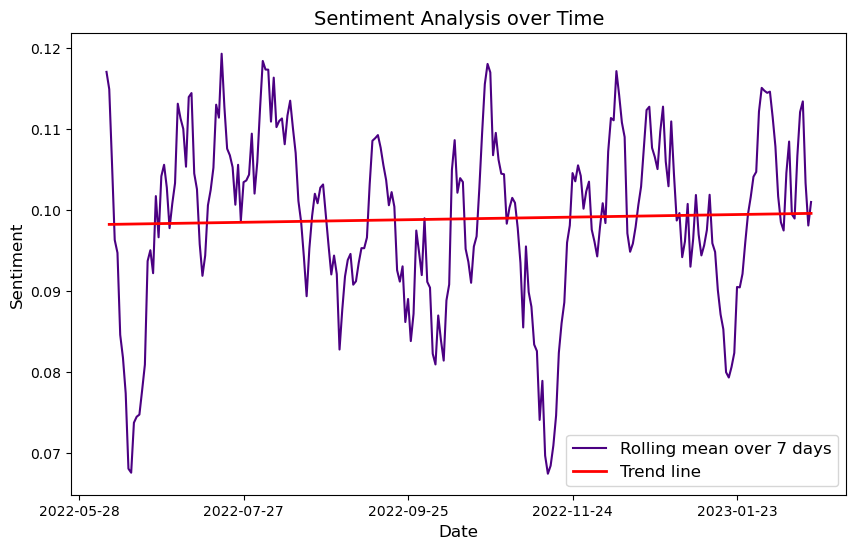

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# create a sample dataset with datetime values and data
dates = df['date']
data = pd.DataFrame()
data['Sentiment'] = df['Sentiment']
data['date'] = dates
daily_avg = data.groupby(pd.Grouper(key='date', freq='D')).mean()

# calculate the rolling mean over a window of 7 days
rolling_mean = daily_avg.rolling(window=7).mean()

# create a line plot of the rolling mean over time
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(rolling_mean.index, rolling_mean['Sentiment'], color='indigo', label='Rolling mean over 7 days')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Sentiment', fontsize=12)
ax.set_title('Sentiment Analysis over Time', fontsize=14)
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.legend(fontsize=12)

# add a trend line
rolling_mean = rolling_mean.iloc[7:]
x = np.arange(len(rolling_mean))
y = rolling_mean.values
slope, intercept = np.polyfit(x, y, 1)
ax.plot(rolling_mean.index, intercept + slope * x, 'r', label='Trend line', linewidth=2)
ax.legend(fontsize=12)

plt.show()


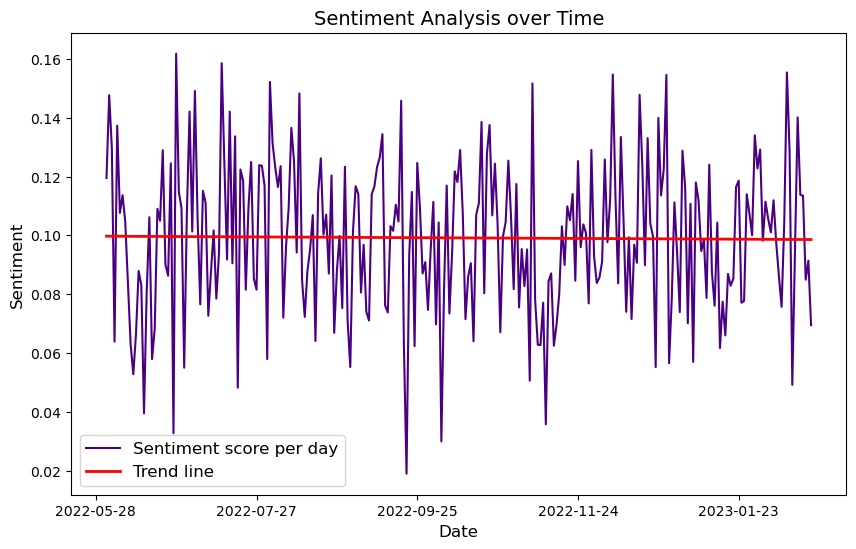

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# create a sample dataset with datetime values and data
dates = df['date']
data = pd.DataFrame()
data['Sentiment'] = df['Sentiment']
data['date'] = dates
daily_avg = data.groupby(pd.Grouper(key='date', freq='D')).mean()

# calculate the rolling mean over a window of 7 days
rolling_mean = daily_avg.rolling(window=7).mean()

# create a line plot of the rolling mean over time
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(daily_avg.index, daily_avg['Sentiment'], color='indigo', label='Sentiment score per day')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Sentiment', fontsize=12)
ax.set_title('Sentiment Analysis over Time', fontsize=14)
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.legend(fontsize=12)

# add a trend line

x = np.arange(len(daily_avg))
y = daily_avg.values
slope, intercept = np.polyfit(x, y, 1)
ax.plot(daily_avg.index, intercept + slope * x, 'r', label='Trend line', linewidth=2)
ax.legend(fontsize=12)

plt.show()